# Emotion Classifier 
The bot of the Center for Daily Mental Conversations of the Center for Mental Health.<br>
You can write to the bot how you went through the day and how you feel, or in fact anything you want and the bot will recognize how you feel and give recommendations accordingly.<br>
In some cases, the bot will detect a disturbed mental state, it will give recommendations for things that can be done to improve the feeling.


![emails](https://digital.ashdod.muni.il/uploads/images/%D7%91%D7%A8%D7%99%D7%90%D7%95%D7%AA-%D7%94%D7%A0%D7%A4%D7%A9-1000x370.jpg)

 

# Table of contents

[<h3>1. Loading, data explorating and preprocessing</h3>](#1)

[<h3>2. Model comparison</h3>](#2)

[<h3>3. Hyperparameter tuning for DecisionTreeClassifier</h3>](#3)

[<h3>4. The DecisionTreeClassifier Model</h3>](#4)

[<h3>5. Example of predictions</h3>](#5)

# 1. Loading, data explorating and preprocessing<a class="anchor" id="1"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from time import perf_counter
import warnings
warnings.filterwarnings(action='ignore')

from IPython.display import Markdown, display
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
df = pd.read_csv('training.csv')

In [2]:
#add description column
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
df['description'] = df['label'].map(labels_dict)

# Display the first 5 rows
df.head(5)

,text,label,description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [3]:
print(f'The dataset as a total of {df.shape[0]} colomns, which are categorized is sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).')

The dataset as a total of 20000 colomns, which are categorized is sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).


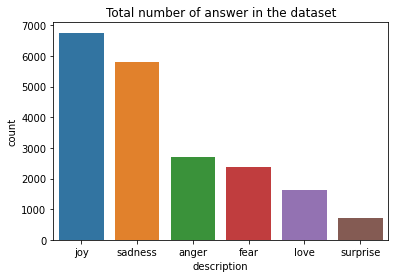

In [4]:
sns.countplot(df['description'],order = df['description'].value_counts(normalize=True).index)
plt.title('Total number of answer in the dataset')
plt.show()

The raw text have a lot of characters beside of the ones of the alphabet, which might provoke issues later. Therefore, the text will be cleaned. Remember that it is a basic model, which won't take count of punctuation.

In [5]:
from nltk.tokenize import RegexpTokenizer

def clean_str(string, reg = RegexpTokenizer(r'[a-z]+')):
    # Clean a string with RegexpTokenizer
    string = string.lower()
    tokens = reg.tokenize(string)
    return " ".join(tokens)

# Create a new column with the cleaned messages
df['text_clean'] = df['text'].apply(lambda string: clean_str(string))

# Display the result
df.head()


,text,label,description,text_clean
0,i didnt feel humiliated,0,sadness,i didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,0,sadness,i can go from feeling so hopeless to so damned...
2,im grabbing a minute to post i feel greedy wrong,3,anger,im grabbing a minute to post i feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,2,love,i am ever feeling nostalgic about the fireplac...
4,i am feeling grouchy,3,anger,i am feeling grouchy


<h2>Distribution of top n-grams 

An n-gram is a contiguous sequence of n items from a given sample of text or speech. It is also a good idea to look at various n-grams to understand which words mainly occur together. For instance, we look at the distribution of unigrams, bigrams, and trigrams across emotions- sadness, anger, and love. You can replicate the same for other categories using this code.

In [6]:
# Creating individual dataframes of different emotions
sadness = df[df['label']==0]['text']
joy = df[df['label']==1]['text']
love = df[df['label']==2]['text']
anger = df[df['label']==3]['text']
fear = df[df['label']==4]['text']
surprise = df[df['label']==5]['text']

In [7]:
# Code to calculate ngrams

from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# calculating unigrmas, bigrams and trigrams for all given emotions

sad_unigrams = get_top_n_gram(sadness.values,(1,1),7)[2:]
joy_unigrams= get_top_n_gram(joy.values,(1,1),7)[2:]
love_unigrams= get_top_n_gram(love.values,(1,1),7)[2:]
anger_unigrams= get_top_n_gram(anger.values,(1,1),7)[2:]
fear_unigrams= get_top_n_gram(fear.values,(1,1),7)[2:]
surprise_unigrams= get_top_n_gram(surprise.values,(1,1),7)[2:]

sad_bigrams = get_top_n_gram(sadness.values,(2,2),7)[2:]
joy_bigrams= get_top_n_gram(joy.values,(2,2),7)[2:]
love_bigrams= get_top_n_gram(love.values,(2,2),7)[2:]
anger_bigrams= get_top_n_gram(anger.values,(2,2),7)[2:]
fear_bigrams= get_top_n_gram(fear.values,(2,2),7)[2:]
surprise_bigrams= get_top_n_gram(surprise.values,(2,2),7)[2:]

sad_trigrams = get_top_n_gram(sadness.values,(3,3),7)[2:]
joy_trigrams= get_top_n_gram(joy.values,(3,3),7)[2:]
love_trigrams= get_top_n_gram(love.values,(3,3),7)[2:]
anger_trigrams= get_top_n_gram(anger.values,(3,3),7)[2:]
fear_trigrams= get_top_n_gram(fear.values,(3,3),7)[2:]
surprise_trigrams= get_top_n_gram(surprise.values,(3,3),7)[2:]


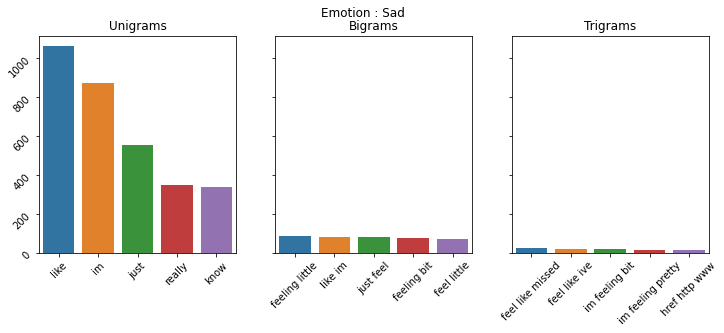

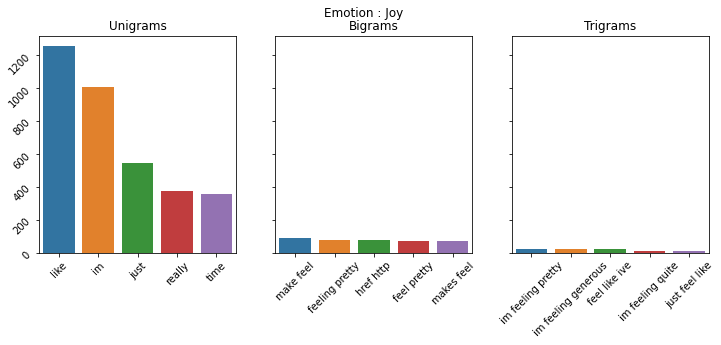

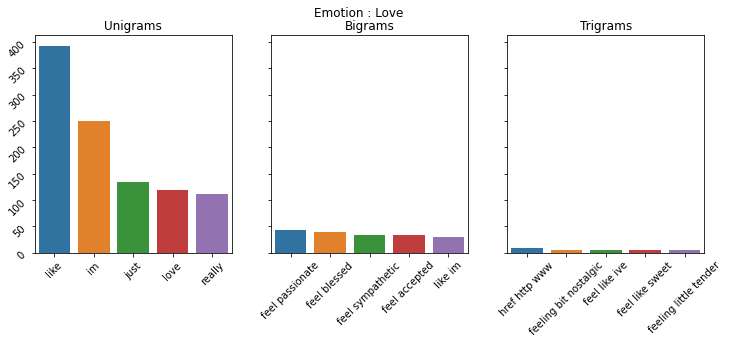

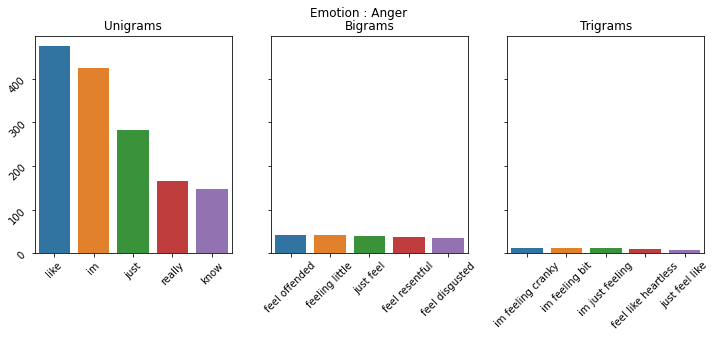

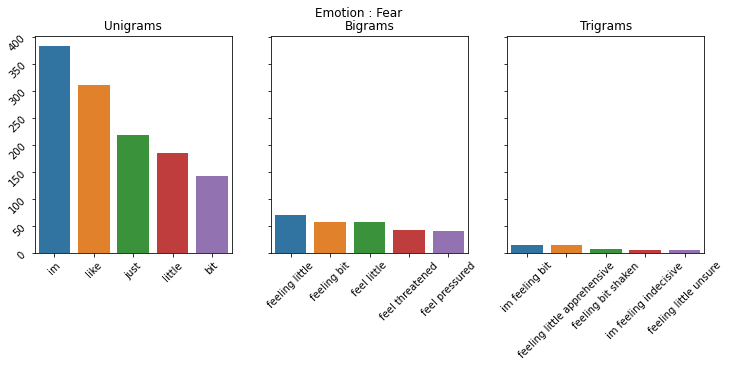

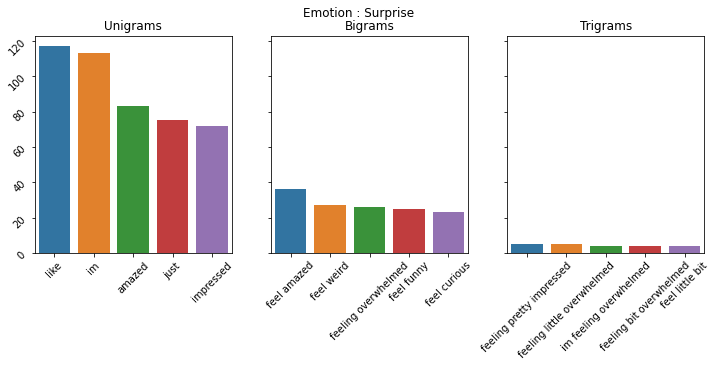

In [8]:
#Visualizing the ngrams 1-3 for the emotions
#sad
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
fig.suptitle('Emotion : Sad')

sns.barplot( list(dict(sad_unigrams).keys()), list(dict(sad_unigrams).values()),ax=axes[0],)
axes[0].set_title('Unigrams')
axes[0].tick_params(labelrotation=45)

sns.barplot( list(dict(sad_bigrams).keys()), list(dict(sad_bigrams).values()),ax=axes[1],)
axes[1].set_title('Bigrams')
axes[1].tick_params(labelrotation=45)

sns.barplot( list(dict(sad_trigrams).keys()), list(dict(sad_trigrams).values()),ax=axes[2],)
axes[2].set_title('Trigrams')
axes[2].tick_params(labelrotation=45)
fig.savefig('sad.png')

#joy
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True)
fig.suptitle('Emotion : Joy')

sns.barplot( list(dict(joy_unigrams).keys()), list(dict(joy_unigrams).values()),ax=axes[0],)
axes[0].set_title('Unigrams')
axes[0].tick_params(labelrotation=45)

sns.barplot( list(dict(joy_bigrams).keys()), list(dict(joy_bigrams).values()),ax=axes[1],)
axes[1].set_title('Bigrams')
axes[1].tick_params(labelrotation=45)

sns.barplot( list(dict(joy_trigrams).keys()), list(dict(joy_trigrams).values()),ax=axes[2],)
axes[2].set_title('Trigrams')
axes[2].tick_params(labelrotation=45)
fig.savefig('joy.png')

#love
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True)
fig.suptitle('Emotion : Love')

sns.barplot( list(dict(love_unigrams).keys()), list(dict(love_unigrams).values()),ax=axes[0],)
axes[0].set_title('Unigrams')
axes[0].tick_params(labelrotation=45)

sns.barplot( list(dict(love_bigrams).keys()), list(dict(love_bigrams).values()),ax=axes[1],)
axes[1].set_title('Bigrams')
axes[1].tick_params(labelrotation=45)

sns.barplot( list(dict(love_trigrams).keys()), list(dict(love_trigrams).values()),ax=axes[2],)
axes[2].set_title('Trigrams')
axes[2].tick_params(labelrotation=45)
fig.savefig('love.png')

#anger
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True)
fig.suptitle('Emotion : Anger')

sns.barplot( list(dict(anger_unigrams).keys()), list(dict(anger_unigrams).values()),ax=axes[0],)
axes[0].set_title('Unigrams')
axes[0].tick_params(labelrotation=45)

sns.barplot( list(dict(anger_bigrams).keys()), list(dict(anger_bigrams).values()),ax=axes[1],)
axes[1].set_title('Bigrams')
axes[1].tick_params(labelrotation=45)

sns.barplot( list(dict(anger_trigrams).keys()), list(dict(anger_trigrams).values()),ax=axes[2],)
axes[2].set_title('Trigrams')
axes[2].tick_params(labelrotation=45)
fig.savefig('anger.png')

#fear
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True)
fig.suptitle('Emotion : Fear')

sns.barplot( list(dict(fear_unigrams).keys()), list(dict(fear_unigrams).values()),ax=axes[0],)
axes[0].set_title('Unigrams')
axes[0].tick_params(labelrotation=45)

sns.barplot( list(dict(fear_bigrams).keys()), list(dict(fear_bigrams).values()),ax=axes[1],)
axes[1].set_title('Bigrams')
axes[1].tick_params(labelrotation=45)

sns.barplot( list(dict(fear_trigrams).keys()), list(dict(fear_trigrams).values()),ax=axes[2],)
axes[2].set_title('Trigrams')
axes[2].tick_params(labelrotation=45)
fig.savefig('fear.png')

#surprise
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True)
fig.suptitle('Emotion : Surprise')

sns.barplot( list(dict(surprise_unigrams).keys()), list(dict(surprise_unigrams).values()),ax=axes[0],)
axes[0].set_title('Unigrams')
axes[0].tick_params(labelrotation=45)

sns.barplot( list(dict(surprise_bigrams).keys()), list(dict(surprise_bigrams).values()),ax=axes[1],)
axes[1].set_title('Bigrams')
axes[1].tick_params(labelrotation=45)

sns.barplot( list(dict(surprise_trigrams).keys()), list(dict(surprise_trigrams).values()),ax=axes[2],)
axes[2].set_title('Trigrams')
axes[2].tick_params(labelrotation=45)
fig.savefig('surprise.png')

In [9]:
# Convert a collection of text documents to a matrix of token counts
#Use Stopwords
#Use N-Grams between 1-2 words as we can see that is necessary above
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words="english",ngram_range = (1, 2))
X = cv.fit_transform(df.text_clean)

# Get the categories
y = df.label

In [10]:
# Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('X.shape',X.shape)
print('y.shape',y.shape)


X.shape (20000, 120746)
y.shape (20000,)


# 2. Model comparison<a class="anchor" id="2"></a>

In [11]:
#Both models (Random Forest, Gradient Boosting) give a low percentage of accuracy during a really long run so they are marked as a note so that the computer can run the code in a reasonable time
models = {
    #"Random Forest": {"model":RandomForestClassifier(), "perf":0}, 
    #"Gradient Boosting": {"model":GradientBoostingClassifier(), "perf":0},
    "XGBoost": {"model":XGBClassifier(eval_metric='mlogloss'), "perf":0},
    "MultinomialNB": {"model":MultinomialNB(), "perf":0},
    "Logistic Regr.": {"model":LogisticRegression(), "perf":0},
    "KNN": {"model":KNeighborsClassifier(), "perf":0},
    "Decision Tree": {"model":DecisionTreeClassifier(), "perf":0},
    "SVM (Linear)": {"model":LinearSVC(), "perf":0},
    "SVM (RBF)": {"model":SVC(), "perf":0}
}

for name, model in models.items():
    start = perf_counter()
    model['model'].fit(X_train, y_train)
    duration = perf_counter() - start
    duration = round(duration,2)
    model["perf"] = duration
    print(f"{name:20} trained in {duration} sec")

XGBoost              trained in 23.39 sec
MultinomialNB        trained in 0.09 sec
Logistic Regr.       trained in 24.53 sec
KNN                  trained in 0.0 sec
Decision Tree        trained in 30.27 sec
SVM (Linear)         trained in 5.43 sec
SVM (RBF)            trained in 216.17 sec


In [12]:
models_acc = []
for name, model in models.items():
    models_acc.append([name, model["model"].score(X_test, y_test),model["perf"]])

In [13]:
df_acc = pd.DataFrame(models_acc)
df_acc.columns = ['Model', 'Accuracy w/o scaling', 'Training time (sec)']
df_acc.sort_values(by = 'Accuracy w/o scaling', ascending = False, inplace=True)
df_acc.reset_index(drop = True, inplace=True)
df_acc

,Model,Accuracy w/o scaling,Training time (sec)
0,SVM (Linear),0.90600,5.43
1,Logistic Regr.,0.89950,24.53
2,XGBoost,0.89550,23.39
3,Decision Tree,0.86875,30.27
4,SVM (RBF),0.80150,216.17
5,MultinomialNB,0.79350,0.09
6,KNN,0.45950,0.00


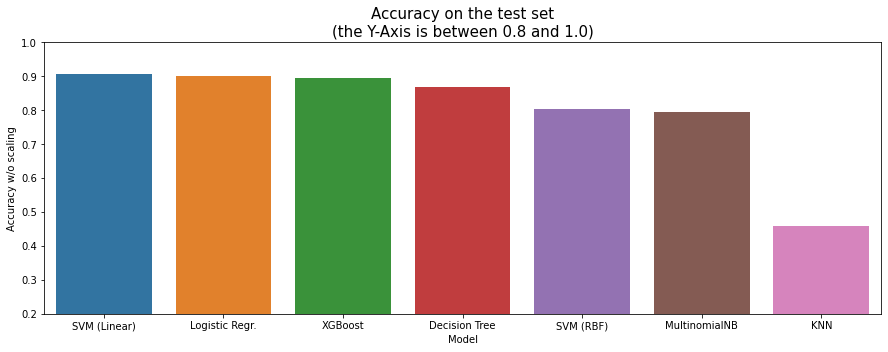

In [14]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Model', y = 'Accuracy w/o scaling', data = df_acc)
plt.title('Accuracy on the test set\n(the Y-Axis is between 0.8 and 1.0)', fontsize = 15)
plt.ylim(0.2,1)
plt.show()

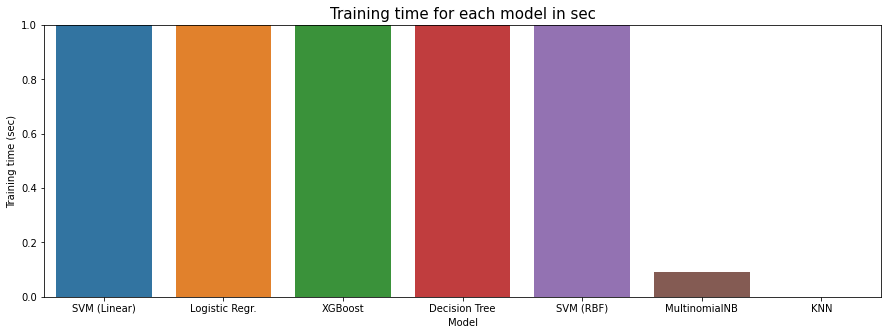

In [15]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Model', y = 'Training time (sec)', data = df_acc)
plt.title('Training time for each model in sec', fontsize = 15)
plt.ylim(0,1)
plt.show()

# 3. Hyperparameter tuning for LinearSVC<a class="anchor" id="3"></a>

SVM (Linear) gives the best result on the test set on with good running time. In the following part, we'll choose the LinearSVC and try various hyperparameters to optimize it.

In [16]:
# Find the best hyperparameter with GridSearchCV
# Exhaustive search over specified parameter values for an estimator.

from sklearn.model_selection import GridSearchCV

params = {
            'C': [0.1, 0.5, 1.0, 10.0],
         }

linear_svc_classifier_grid = GridSearchCV(LinearSVC(random_state=1, max_iter=1000000), param_grid=params, n_jobs=-1, cv=5, verbose=5)
linear_svc_classifier_grid.fit(X_train,y_train)

print('Train Accuracy : %.3f'%linear_svc_classifier_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%linear_svc_classifier_grid.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%linear_svc_classifier_grid.best_score_)
print('Best Parameters : ',linear_svc_classifier_grid.best_params_)




Fitting 5 folds for each of 4 candidates, totalling 20 fits
Train Accuracy : 0.996
Test Accuracy : 0.910
Best Accuracy Through Grid Search : 0.905
Best Parameters :  {'C': 0.5}


In [17]:
# Display the best hyperparameters
linear_svc_classifier_grid.best_params_

{'C': 0.5}

# 4. The LinearSVC Model<a class="anchor" id="4"></a>

In [18]:
# Create Decision Tree classifer object
clf = LinearSVC(C= 0.5)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
# Model Accuracy, how often is the classifier correct?
printmd(f'## Accuracy: {round(accuracy_score(y_test,y_pred),4)*100}%\n')


## Accuracy: 90.98%


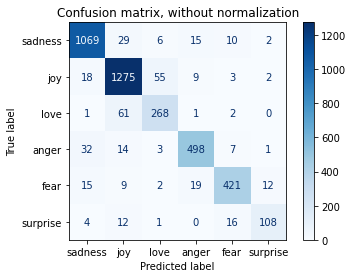

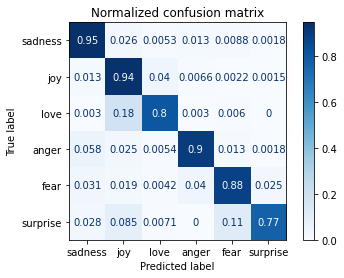

In [19]:
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.show()

In [20]:
print(classification_report(y_test,y_pred, target_names=class_names))

              precision    recall  f1-score   support

     sadness       0.94      0.95      0.94      1131
         joy       0.91      0.94      0.92      1362
        love       0.80      0.80      0.80       333
       anger       0.92      0.90      0.91       555
        fear       0.92      0.88      0.90       478
    surprise       0.86      0.77      0.81       141

    accuracy                           0.91      4000
   macro avg       0.89      0.87      0.88      4000
weighted avg       0.91      0.91      0.91      4000



# 5. Example of predictions<a class="anchor" id="5"></a>

In [21]:
#The answers will appear below the text that users enter
answer = ["""I feel you are sad <br>
Here are some tips to help you get over the sadness:
1. Look for support from people who make you feel safe and cared for.
2. Make face-time a priority.
3. Try to keep up with social activities even if you don’t feel like it.
4. Find ways to support others.""",
"""I feel you are joyful<br>
Keep it up!<br>
The best vitamin to be a happy person is B positive.""",
"""I feel you are in love<br>
Love is a precious feeling, not felt by everyone only felt by lucky one.""",
"""I feel you're angry<br>
Here are some tips for releasing anger:
1. Think before you speak
2. Once you're calm, express your anger
3. Get some exercise
4. Take a timeout
5. Identify possible solutions""",
"""I feel you're scared<br>
Here are steps to help you deal with fear:
1. Breathe through panic
2. Face your fears
3. Don't try to be perfect
4. Visualise a happy place""",
"""I feel you are surprised<br>
Surprise is a feeling that disappears after a few moments.<br>
It is best to go to a quiet place, take a deep breath and then return calm"""
]

In [22]:
def display_result(df, number=2):
    for i in range(number):
        msg = df['text_clean'].iloc[i]
        label = df["description"].iloc[i]
        msg_vec = cv.transform([msg])
        pred_label = clf.predict(msg_vec)
        
        printmd(f"**Real: {label}, Predicted: {labels_dict[pred_label[0]]}**")
        printmd(f"**Message:** {msg}")
        printmd(f"**Answer:** {answer[pred_label[0]]}")
        printmd("_______________________________________________________________")
    
df_0 = df[df['description'] == 'sadness']
df_1 = df[df['description'] == 'joy']
df_2 = df[df['description'] == 'love']
df_3 = df[df['description'] == 'anger']
df_4 = df[df['description'] == 'fear']
df_5 = df[df['description'] == 'surprise']
display_result(df_0)
display_result(df_1)
display_result(df_2)
display_result(df_3)
display_result(df_4)
display_result(df_5)


**Real: sadness, Predicted: sadness**

**Message:** i didnt feel humiliated

**Answer:** I feel you are sad <br>
Here are some tips to help you get over the sadness:
1. Look for support from people who make you feel safe and cared for.
2. Make face-time a priority.
3. Try to keep up with social activities even if you don’t feel like it.
4. Find ways to support others.

_______________________________________________________________

**Real: sadness, Predicted: sadness**

**Message:** i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake

**Answer:** I feel you are sad <br>
Here are some tips to help you get over the sadness:
1. Look for support from people who make you feel safe and cared for.
2. Make face-time a priority.
3. Try to keep up with social activities even if you don’t feel like it.
4. Find ways to support others.

_______________________________________________________________

**Real: joy, Predicted: joy**

**Message:** i have been with petronas for years i feel that petronas has performed well and made a huge profit

**Answer:** I feel you are joyful<br>
Keep it up!<br>
The best vitamin to be a happy person is B positive.

_______________________________________________________________

**Real: joy, Predicted: joy**

**Message:** i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter

**Answer:** I feel you are joyful<br>
Keep it up!<br>
The best vitamin to be a happy person is B positive.

_______________________________________________________________

**Real: love, Predicted: love**

**Message:** i am ever feeling nostalgic about the fireplace i will know that it is still on the property

**Answer:** I feel you are in love<br>
Love is a precious feeling, not felt by everyone only felt by lucky one.

_______________________________________________________________

**Real: love, Predicted: love**

**Message:** i feel romantic too

**Answer:** I feel you are in love<br>
Love is a precious feeling, not felt by everyone only felt by lucky one.

_______________________________________________________________

**Real: anger, Predicted: anger**

**Message:** im grabbing a minute to post i feel greedy wrong

**Answer:** I feel you're angry<br>
Here are some tips for releasing anger:
1. Think before you speak
2. Once you're calm, express your anger
3. Get some exercise
4. Take a timeout
5. Identify possible solutions

_______________________________________________________________

**Real: anger, Predicted: anger**

**Message:** i am feeling grouchy

**Answer:** I feel you're angry<br>
Here are some tips for releasing anger:
1. Think before you speak
2. Once you're calm, express your anger
3. Get some exercise
4. Take a timeout
5. Identify possible solutions

_______________________________________________________________

**Real: fear, Predicted: fear**

**Message:** i feel as confused about life as a teenager or as jaded as a year old man

**Answer:** I feel you're scared<br>
Here are steps to help you deal with fear:
1. Breathe through panic
2. Face your fears
3. Don't try to be perfect
4. Visualise a happy place

_______________________________________________________________

**Real: fear, Predicted: fear**

**Message:** i now feel compromised and skeptical of the value of every unit of work i put in

**Answer:** I feel you're scared<br>
Here are steps to help you deal with fear:
1. Breathe through panic
2. Face your fears
3. Don't try to be perfect
4. Visualise a happy place

_______________________________________________________________

**Real: surprise, Predicted: surprise**

**Message:** ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny

**Answer:** I feel you are surprised<br>
Surprise is a feeling that disappears after a few moments.<br>
It is best to go to a quiet place, take a deep breath and then return calm

_______________________________________________________________

**Real: surprise, Predicted: surprise**

**Message:** i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies

**Answer:** I feel you are surprised<br>
Surprise is a feeling that disappears after a few moments.<br>
It is best to go to a quiet place, take a deep breath and then return calm

_______________________________________________________________

# B-Well!

![simple-powerfull](https://img.freepik.com/free-vector/bot-chat-say-hi-robots-that-are-programmed-talk-customers-online_68708-622.jpg?size=626&ext=jpg)

# sources:
https://huggingface.co/datasets/emotion  database<br>
https://numpy.org/learn/ <br>
https://scikit-learn.org/stable/<br>
https://www.nltk.org/api/nltk.lm.html <br>
https://www.kaggle.com/parulpandey/exploratory-data-analysis-of-the-emotion-dataset/notebook <br>
https://www.mentalhealth.gov/ <br>